In [1]:
import sys
print(sys.prefix)

c:\Users\RomanGu\.conda\envs\jupyter-nlp


In [2]:
# !pip install -qq transformers torch pandas psutil scikit-learn 
# !pip install -qq -U watermark seaborn
!pip install -qq -r ..\requirements\pytorch_requirements.txt

Este código carga los conjuntos de datos de entrenamiento y prueba desde los archivos CSV utilizando Pandas. Luego codifica las etiquetas categóricas como números enteros utilizando un objeto LabelEncoder. Se define una clase personalizada para representar los conjuntos de datos como objetos Dataset de PyTorch. Esta clase tokeniza el texto utilizando el tokenizer BERT y devuelve los tensores de entrada para el modelo junto con la etiqueta correspondiente. Luego se crean objetos Dataset para los conjuntos de datos de entrenamiento y prueba y se crean DataLoaders para ellos. El resto del código es similar al ejemplo anterior.

Una vez termina el entrenamiento del modelo, se guarda un csv con los estadísticos importantes para su posterior comparación:
- datetime de la realizacion de la prueba
- tamaño de la muestra
- modelo bert utilizado.
- Tiempo de entrenamiento
- memoria utilizada
- Si ha utilizado GPU
- Uso de memoria de GPU
- estadísticos de precisión del accuracy_score.

# Inicio de la carga y carga de librerias

In [3]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score
import time
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import psutil
import csv
from datetime import datetime

import urllib.request
import os

if not os.path.exists('./sample_data'):
    os.makedirs('./sample_data')


# Definir el nombre del modelo BERT utilizado
bert_model_name = 'google/bert_uncased_L-4_H-256_A-4' #'bert-base-uncased'

# Cargar el tokenizer y el modelo pre-entrenado de BERT
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
model = BertForSequenceClassification.from_pretrained(bert_model_name, num_labels=4)

# Cargar los conjuntos de datos de entrenamiento y prueba desde los archivos CSV
base_url = "https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Public/data"
train_url = base_url+"/news_category_train.csv"
test_url = base_url+"/news_category_test.csv"

urllib.request.urlretrieve(train_url, "./sample_data/news_category_train.csv")
urllib.request.urlretrieve(test_url, "./sample_data/news_category_test.csv")

train_data = pd.read_csv ("./sample_data/news_category_train.csv",sep=",",engine="c",on_bad_lines='skip')
print(train_data.head())

test_data = pd.read_csv ("./sample_data/news_category_test.csv",sep=",",engine="c",on_bad_lines='skip')

c:\Users\RomanGu\.conda\envs\jupyter-nlp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if yo

   category                                        description
0  Business   Short sellers, Wall Street's dwindling band o...
1  Business   Private investment firm Carlyle Group, which ...
2  Business   Soaring crude prices plus worries about the e...
3  Business   Authorities have halted oil export flows from...
4  Business   Tearaway world oil prices, toppling records a...


In [4]:
# df_train.shape, df_val.shape, df_test.shape

print("Training Dataset shape: " + str(train_data.shape))
# print("Evaluation Dataset shape: " + str(df_val.shape))
print("Test Dataset shape: " + str(test_data.shape))
     

Training Dataset shape: (119998, 2)
Test Dataset shape: (7600, 2)


# imprimir versiones

In [5]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.11.3
IPython version      : 8.13.2

numpy       : 1.24.3
pandas      : 2.0.1
torch       : 2.0.1
transformers: 4.29.2



# configurar visualizaciones


In [6]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

# visualizar la longitud de los tokens de cada sentencia


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


CPU times: total: 0 ns
Wall time: 0 ns


C:\Users\RomanGu\AppData\Local\Temp\ipykernel_22072\3920738088.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


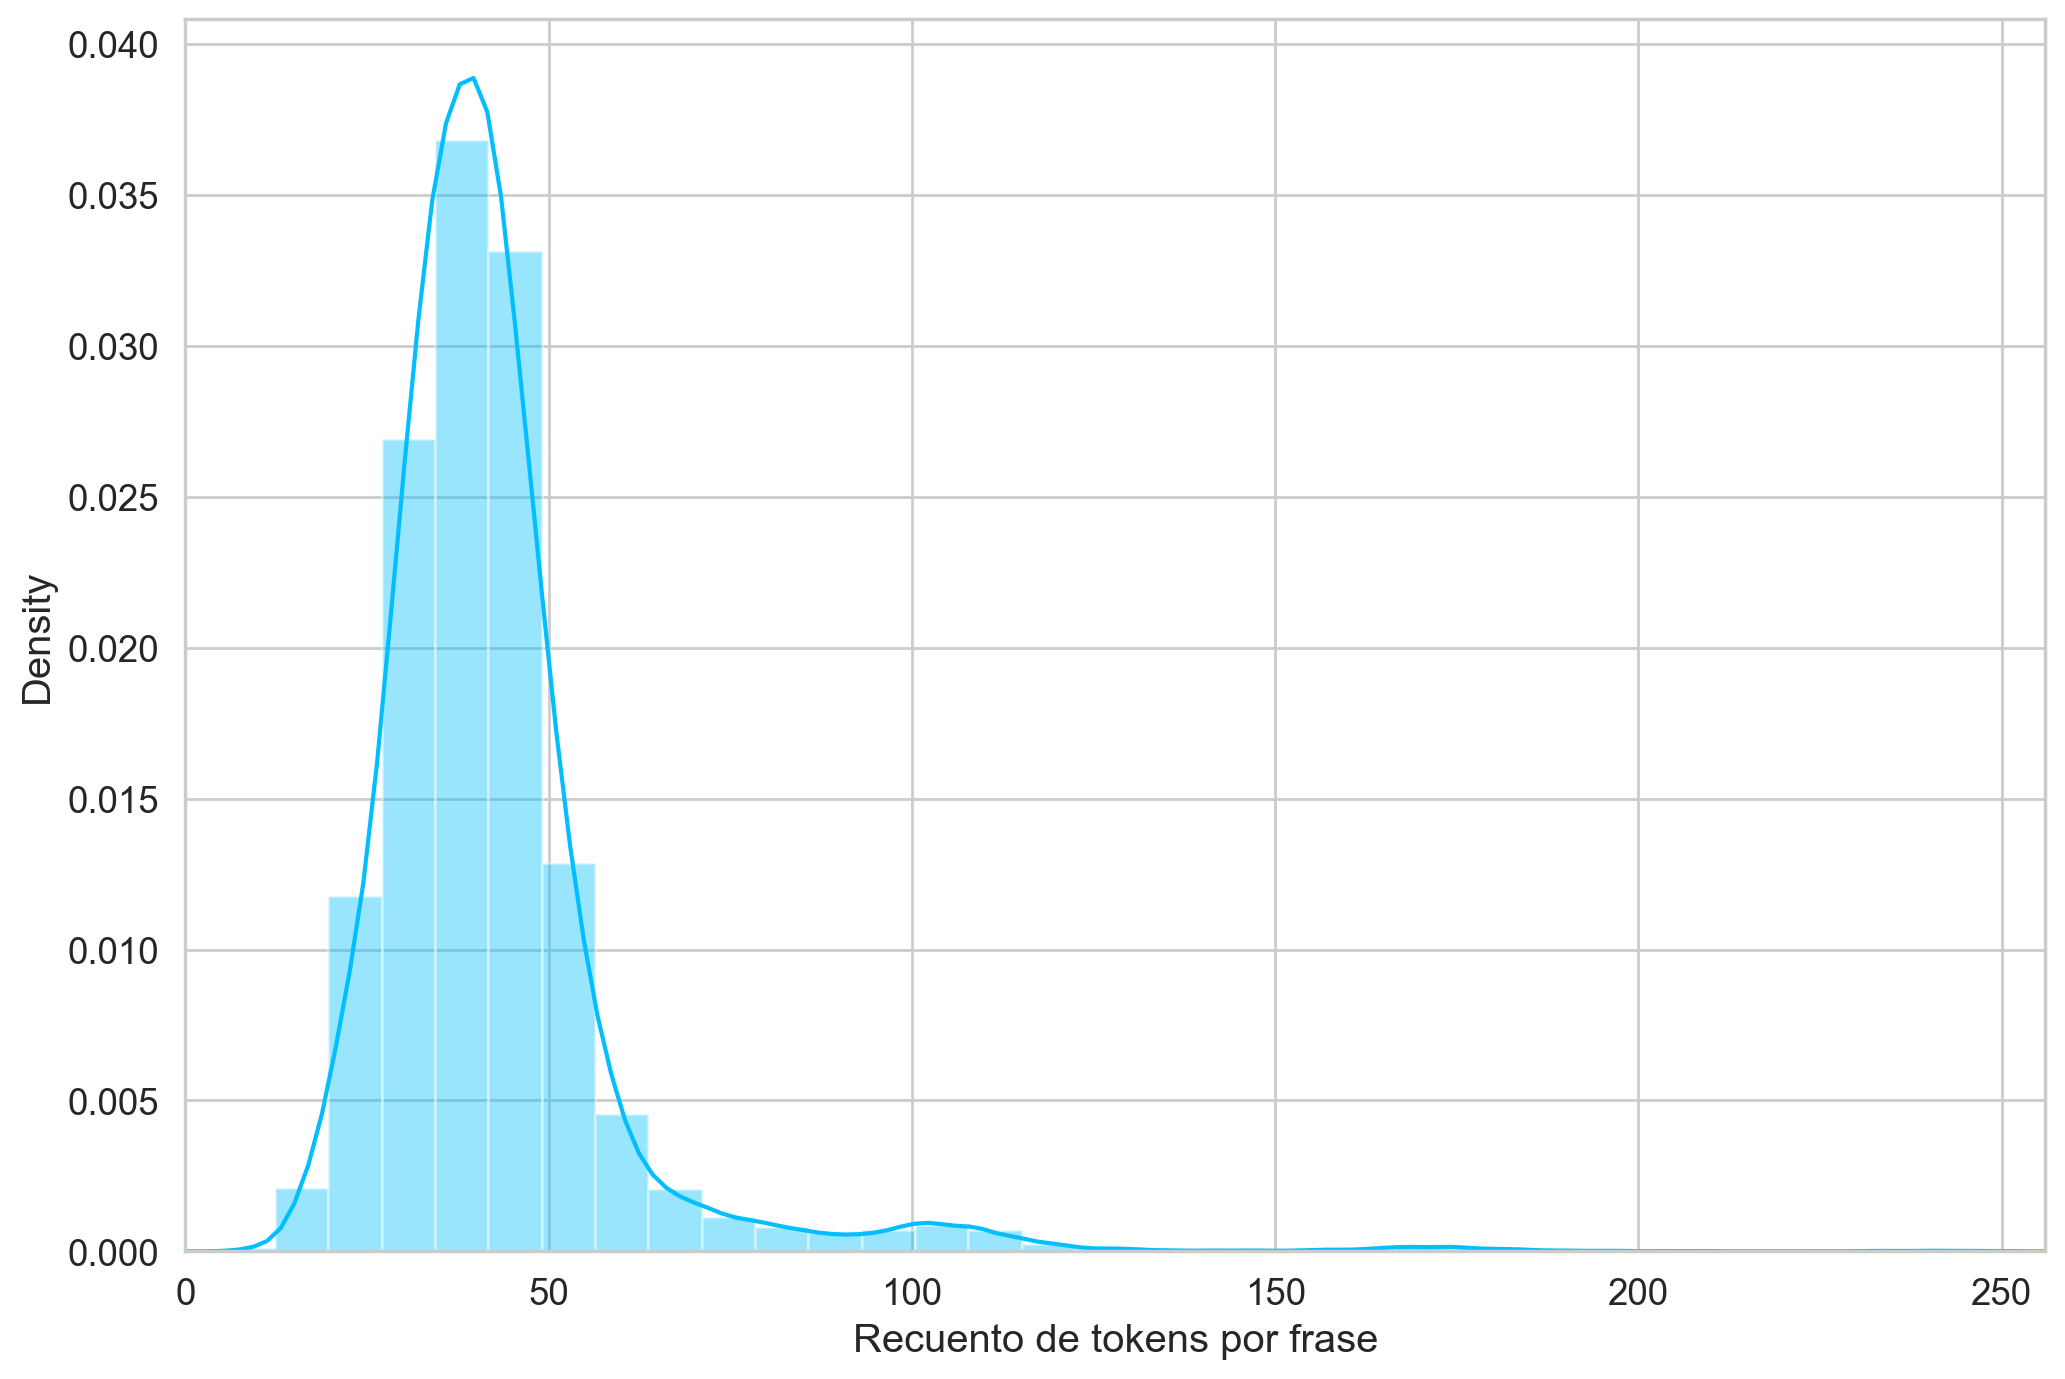

In [7]:
%time
token_lens = []

for txt in train_data.description:
  tokens = tokenizer.encode(txt,
                            max_length=512
                            # truncation=True
                            )
  token_lens.append(len(tokens))
# lo visualizamos para hacernos una idea
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Recuento de tokens por frase');


# configurar el tamaño total del tensor


In [8]:
max_len = 80

In [9]:
# Codificar las etiquetas categóricas como números enteros
label_encoder = LabelEncoder()
train_data['category'] = label_encoder.fit_transform(train_data['category'])
test_data['category'] = label_encoder.transform(test_data['category'])

# Definir una clase personalizada para representar los conjuntos de datos como objetos Dataset de PyTorch
class AGNewsDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Obtener la fila correspondiente al índice dado
        row = self.data.iloc[idx]

        # Tokenizar el texto y obtener los tensores de entrada para el modelo BERT
        inputs = self.tokenizer.encode_plus(
            row['description'],
            add_special_tokens=True,
            return_token_type_ids=False,
            return_attention_mask=True,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
            max_length=max_len
            )

        # Obtener la etiqueta correspondiente
        label = torch.tensor(row['category'])

        # Devolver los tensores de entrada y la etiqueta como un diccionario
        return {**inputs, 'labels': label}

# Crear objetos Dataset para los conjuntos de datos de entrenamiento y prueba
train_dataset = AGNewsDataset(train_data, tokenizer)
test_dataset = AGNewsDataset(test_data, tokenizer)

# Crear DataLoaders para los conjuntos de datos de entrenamiento y prueba
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

# Mover el modelo al dispositivo adecuado (GPU si está disponible)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Configurar el optimizador y la función de pérdida
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# Entrenar el modelo y guardar estadísticas en un archivo CSV
with open(datetime.now().strftime("%Y_%m_%d_%H%M%S")+"TFM_EXPERIMENTO_1_STATS_PYTHON"+'.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['experiment_name','datetime', 'sample_size', 'bert_model', 'training_time', 'memory_usage', 'gpu_usage', 'gpu_memory_usage', 'accuracy'])

    model.train()
    for epoch in range(3):
        start_time = time.time()
        for batch in train_loader:
            # Mover los datos al dispositivo adecuado
            input_ids = batch['input_ids'].squeeze().to(device)
            attention_mask = batch['attention_mask'].squeeze().to(device)
            labels = batch['labels'].to(device)

            # Calcular las predicciones y la pérdida 
            # hace falta convertir to long() sino da error // expected scalar type Long but found Int al menos en el modo CPU
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels.long())
            loss = outputs.loss

            # Realizar una actualización de los parámetros del modelo
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    end_time = time.time()
    training_time = end_time - start_time

    memory_usage = psutil.virtual_memory().percent

    gpu_usage = torch.cuda.is_available()
    gpu_memory_usage = torch.cuda.memory_allocated() if gpu_usage else 0

    # Evaluar el modelo en el conjunto de datos de prueba
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in test_loader:
            # Mover los datos al dispositivo adecuado
            input_ids = batch['input_ids'].squeeze().to(device)
            attention_mask = batch['attention_mask'].squeeze().to(device)
            labels = batch['labels'].to(device)

            # Calcular las predicciones del modelo
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            # Almacenar las predicciones y las etiquetas verdaderas
            predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)

    writer.writerow(['AG_NEWS_PYTHON',datetime.now(), len(train_data), bert_model_name, training_time, memory_usage, gpu_usage, gpu_memory_usage, accuracy])


Se crea una función `predict` para hacer una predicción con el modelo BERT que se ha entrenado utilizando un texto de entrada X. La función toma como argumentos el modelo y el texto de entrada

In [10]:
def predict(model, text):
    # Tokenizar el texto y obtener los tensores de entrada para el modelo BERT
    inputs = tokenizer.encode_plus(
                text,
                add_special_tokens=True,
                return_token_type_ids=False,
                return_attention_mask=True,
                padding='max_length', 
                truncation=True,
                return_tensors='pt')
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Calcular la predicción del modelo
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    # Obtener la etiqueta predicha
    predicted_label = torch.argmax(logits, dim=1).item()
    predicted_label = label_encoder.inverse_transform([predicted_label])[0]

    return predicted_label

 ## prediccion una palabra

In [11]:
text = 'In Madrid there will be a sunny weekend'
predicted_label = predict(model, text)
print(f'Texto: {text}')
print(f'Etiqueta predicha: {predicted_label}')

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Texto: In Madrid there will be a sunny weekend
Etiqueta predicha: Sports


In [12]:
text = 'after the match everything went dark, 1 death 2 injuries'
predicted_label = predict(model, text)
print(f'Texto: {text}')
print(f'Etiqueta predicha: {predicted_label}')

Texto: after the match everything went dark, 1 death 2 injuries
Etiqueta predicha: Sports


In [13]:
text = 'Today is sunny and we are gonna enjoy it'
predicted_label = predict(model, text)
print(f'Texto: {text}')
print(f'Etiqueta predicha: {predicted_label}')

Texto: Today is sunny and we are gonna enjoy it
Etiqueta predicha: Business
